In [1]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

torch.set_default_device(device)


/home/akseli/dippa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse problem 

In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

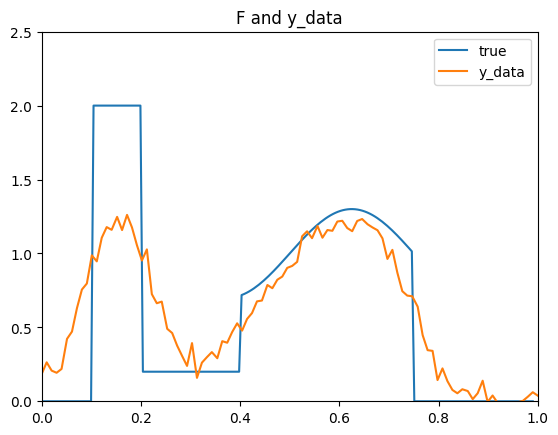

In [4]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.05)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [26]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float().cuda()
y_train = torch.from_numpy(y_data).float().cuda()


TypeError: expected np.ndarray (got Tensor)

## Load BNN model for signals, Prior

In [27]:
bnn_model = BNN(h1=N, h2=n)

In [28]:
predictive = torch.load('../svi_model.pt')

#### Generate prior for the y

In [30]:
prior_bnn = predictive(y_train)

In [31]:
prior_bnn['obs'].shape

torch.Size([5000, 200])

#### Plotting the prior

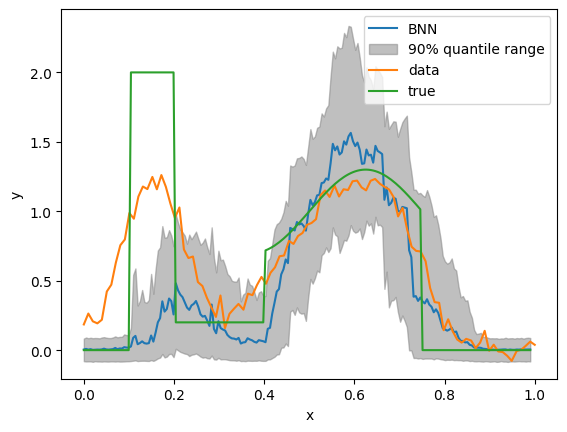

In [37]:
# Calculate mean and quantiles
mean_preds = torch.mean(preds, axis=0)
lower_quantile = torch.quantile(preds, 0.05, axis=0)
upper_quantile = torch.quantile(preds, 0.95, axis=0)

# Plot the mean prediction
plt.plot(x, mean_preds, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data.cpu(), label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


## Sampling with NUTS

It is not working yet, I can't seem to sample the prior correctly. Have asked Pyro forum for help. 

The code works with just using a Gaussian prior. 

In [38]:
prior_bnn = prior_bnn['obs']
prior_bnn.shape

torch.Size([5000, 200])

In [24]:
import pyro.infer.autoguide
import pyro
import pyro.distributions as dist
import pyro.infer

from torch.distributions import constraints
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoNormal
from pyro.ops.indexing import Vindex


predictive = pyro.poutine.block(predictive, hide_all=True)
A = torch.tensor(A, dtype=torch.float32).cuda()
y_data = torch.tensor(y_data, dtype=torch.float32)

f_gpu = torch.tensor(f, dtype=torch.float32)

@config_enumerate
def inverse_model(A, y_data):
    n = A.size(1)  # Number of features
    
    # Prior distribution for omega, sampled from the empirical distribution
    prior_samples = pyro.param('prior', prior_bnn.T.cuda())
    
    print(f'prior_samples shape: {prior_samples.shape}')

    
    x = pyro.sample("x", dist.Categorical(torch.ones(200)))
    y = pyro.sample("y", dist.Categorical(torch.ones(5000)))

    with pyro.plate("z_plate", 1):
        omega = Vindex(prior_samples)[...,:,x] 

    sigma = pyro.sample("sigma", dist.Uniform(0., 0.05)).to(A.device)

    # Linear model
    print(f'omega shape: {omega.shape}')
    mu = A @ omega

    # Likelihood (sampling distribution) of observations
    with pyro.plate("data", y_data.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y_data)
    
    return omega

# Define the NUTS sampler
inverse_nuts_kernel = pyro.infer.NUTS(inverse_model, init_strategy=pyro.infer.autoguide.init_to_sample())
mcmc = pyro.infer.MCMC(inverse_nuts_kernel, num_samples=1000, warmup_steps=10)

with pyro.validation_enabled():
    res = mcmc.run(A, y_data)
# Run MCMC
#mcmc.run(A, y_data)


Warmup:   0%|          | 0/1010 [00:00, ?it/s]

prior_samples shape: torch.Size([200, 5000])
omega shape: torch.Size([200])
prior_samples shape: torch.Size([200, 5000])
omega shape: torch.Size([200, 1, 200])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [200, 200] but got: [200, 1].
Trace Shapes:                  
 Param Sites:                  
        prior          200 5000
Sample Sites:                  
       x dist                 |
        value      200   1    |
       y dist                 |
        value 5000   1   1    |
 z_plate dist                 |
        value            1    |
   sigma dist                 |
        value                 |

In [ ]:
samples = prior_bnn.T
log_wgts = torch.ones(samples.shape)

emp = dist.Empirical(samples, log_wgts)
emp.sample().detach()
emp_samples = [emp.sample().detach() for _ in range(10000)]


#plt.hist(emp_samples)

In [ ]:
# Extract samples
posterior_samples = mcmc.get_samples()

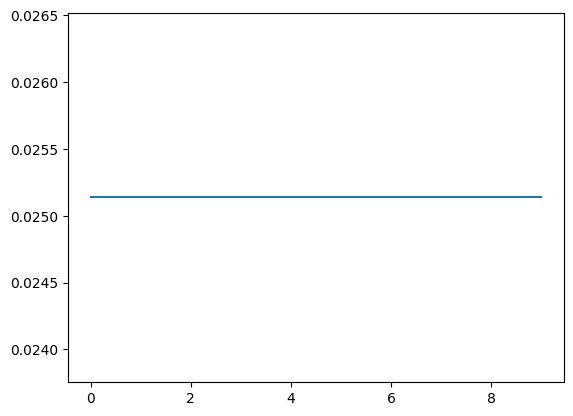

In [ ]:
sig = posterior_samples['sigma'].cpu().numpy()
plt.plot(sig)

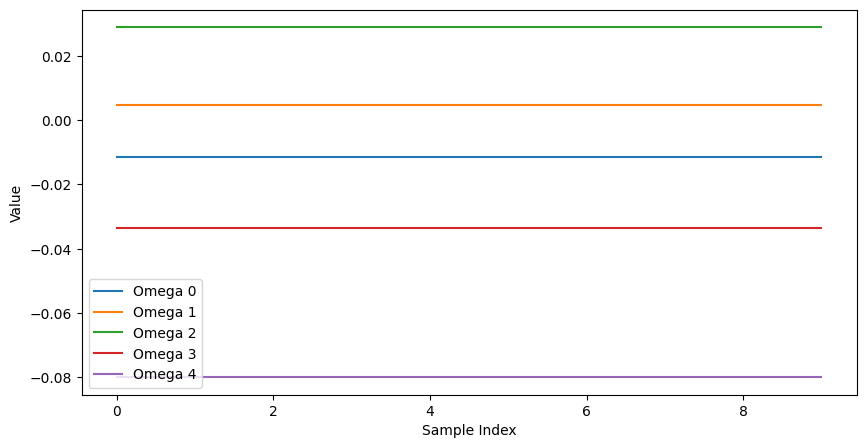

In [ ]:
# Analyze the results
omega_samples = posterior_samples['omega'].cpu().numpy()


# Optional: Visualize the samples
import matplotlib.pyplot as plt

# Plot the omega samples for a few dimensions as an example
plt.figure(figsize=(10, 5))
for i in range(min(5, omega_samples.shape[1])):
    plt.plot(omega_samples[:, i], label=f'Omega {i}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
inverse_predictive = pyro.infer.Predictive(model=inverse_model,
                                           posterior_samples=mcmc.get_samples(), 
                                           num_samples=5000)

preds = inverse_predictive(A, y_data)

/home/akseli/dippa/.venv/lib/python3.10/site-packages/pyro/infer/predictive.py:202: UserWarning: Sample's leading dimension size 50 is different from the provided 5000 num_samples argument. Defaulting to 50.
  warnings.warn(


In [ ]:
preds

{'obs': tensor([[ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436],
         [ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436],
         [ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436],
         ...,
         [ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436],
         [ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436],
         [ 0.1667,  0.2061,  0.1615,  ...,  0.0113, -0.0533,  0.0436]],
        device='cuda:0')}

In [ ]:
a = posterior_samples['omega']

In [ ]:
a.shape

torch.Size([50, 200])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 1., 1.,
        2., 1., 0., 5., 1., 1., 1., 4., 2., 5., 2., 0., 1., 1., 1., 4., 3.,
        3., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([-0.28412184, -0.26848584, -0.25284982, -0.23721381, -0.22157779,
        -0.20594178, -0.19030577, -0.17466976, -0.15903375, -0.14339773,
        -0.12776172, -0.11212571, -0.0964897 , -0.08085369, -0.06521767,
        -0.04958166, -0.03394565, -0.01830964, -0.00267363,  0.01296239,
         0.0285984 ,  0.04423441,  0.05987042,  0.07550643,  0.09114245,
         0.10677846,  0.12241447,  0.13805048,  0.15368649,  0.16932251,
         0.18495852,  0.20059453,  0.21623054,  0.23186655,  0.24750257,
         0.26313859,  0.27877459,  0.29441059,  0.31004661,  0.32568264,
         0.34131864,  0.35695463,  0.37259066,  0.38822669,  0.40386268,
         0.41949868,  0.43513471,  0.45077074,  0.46640673,  0.48204273,
         0.49767876]),
 <BarContainer object

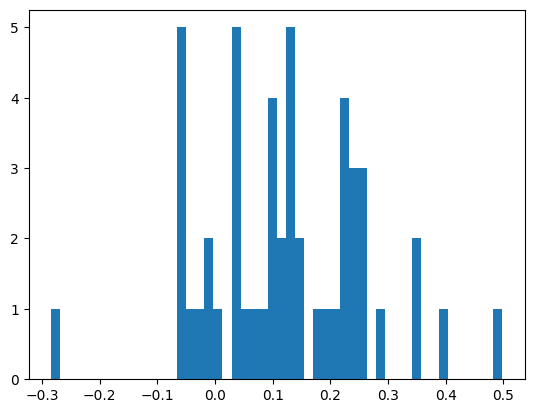

In [ ]:
plt.hist(a[:,0].cpu(), bins=50)

In [ ]:
posterior_samples['sigma']

tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500], device='cuda:0')

Text(0.5, 1.0, 'Setup of the problem')

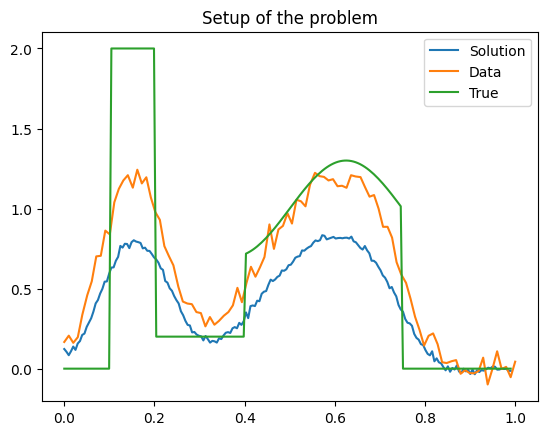

In [ ]:
plt.plot(x, torch.mean(a, axis=0).cpu())
plt.plot(t, y_data.cpu())
plt.plot(x, f)
plt.legend(['Solution', 'Data', 'True'])
plt.title('Setup of the problem')
#plt.savefig('../plot_from_dev/working_gaussian.png')

# Fitting BNN to different signals and learning parameters